In [ ]:
!pip install praw pandas seaborn scipy

In [1]:
import csv
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns

from utils import *

sns.set_theme()

In [54]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [2]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [2]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

# Searching for posts by keyword

This won't find comments with the keyword but whatever, could be useful for giving us an idea of which subreddits have which words

In [47]:
keyword_listings = search(
    reddit.subreddit("all"),
    " OR ".join(f"{keyword}~" for keyword in keywords),
)

In [59]:
with open("search-all-by-keyword.csv", "a") as file:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)

    i = 0
    for submission in keyword_listings:
        writer.writerow(comment_relevant_fields(submission))
        i += 1
        if i > 10:
            break

# Getting comments from a post

In [3]:
listing = reddit.subreddit("unix").search('*', params={ "after": "t3_18zyt6g", "restrict_sr": True })
submissions = list(listing)
submissions

Fetching: GET https://oauth.reddit.com/r/unix/search/ at 1706734256.1732607
Data: None
Params: {'after': 't3_18zyt6g',
 'limit': 100,
 'q': '*',
 'raw_json': 1,
 'restrict_sr': True,
 'sort': 'relevance',
 'syntax': 'lucene',
 't': 'all'}
Response: 200 (62399 bytes) (rst-177:rem-599.0:used-1 ratelimit) at 1706734258.9487572


[Submission(id='1865xk2'),
 Submission(id='18qw8g9'),
 Submission(id='12pol3l'),
 Submission(id='17nn015'),
 Submission(id='18m7ea8'),
 Submission(id='17rre4b'),
 Submission(id='181hlcv'),
 Submission(id='zxulj4'),
 Submission(id='17jgifc'),
 Submission(id='18argdy'),
 Submission(id='18k6tli'),
 Submission(id='17tsw5v'),
 Submission(id='110nkii'),
 Submission(id='18jhs81'),
 Submission(id='17w07g9'),
 Submission(id='11bs899'),
 Submission(id='17l0qif'),
 Submission(id='17e2r50'),
 Submission(id='189vzyq'),
 Submission(id='17u0tl6'),
 Submission(id='18bcwv3'),
 Submission(id='17l8aq6'),
 Submission(id='17mtz7p'),
 Submission(id='17jpid4'),
 Submission(id='180l0ea'),
 Submission(id='16fc9dt'),
 Submission(id='184l9kb'),
 Submission(id='17lmjmt'),
 Submission(id='xpb2l8'),
 Submission(id='1856q95'),
 Submission(id='17vas0t'),
 Submission(id='10g0742'),
 Submission(id='17y11qr'),
 Submission(id='17tiiw2'),
 Submission(id='1816txd'),
 Submission(id='15swuun'),
 Submission(id='11wnw56'),
 Su

In [8]:
[s.url for s in submissions]

['https://www.reddit.com/r/unix/comments/1865xk2/some_help_with_openssl_fileenc_from_machine_a_to/',
 'https://www.idatum.net/upgrading-from-netbsd-51-to-10_rc1.html',
 'https://www.reddit.com/r/unix/comments/12pol3l/searching_for_the_most_unusual_desktop_environment/',
 'https://www.reddit.com/r/unix/comments/17nn015/beginner_question_how_to_properly_implement_dup2/',
 'https://www.delhi-magazine.com/education/overview-of-unix-operating-system/',
 'https://www.reddit.com/r/unix/comments/17rre4b/mongoose_not_accepting_callback/',
 'https://www.reddit.com/r/unix/comments/181hlcv/new_to_mac/',
 'https://www.reddit.com/r/unix/comments/zxulj4/fyi_grexorg_dies_on_2023_apr_15/',
 'https://www.reddit.com/r/unix/comments/17jgifc/kali_linux_error/',
 'https://byte-sized.de/uncategorized/freebsd-streaming-mit-chromium-moeglich-dank-widevine-support/#english',
 'https://freebsdfoundation.org/blog/2024-freebsd-community-survey-is-here/',
 'https://i.redd.it/jmkzvzez7zzb1.png',
 'https://i.redd.it/

In [9]:
comments = submissions[0].comments.list()
comments

In [11]:
comments[0].body

'Bash vs zsh won’t make a difference, but Sonoma has LibreSSL 3, and Mojave…doesn’t. I’m not sure what version it does have, but OpenSSL 1.0.2 was contemporary with Mojave so it cant be anything newer. I know for sure there were some breaking changes between 1.0.x and 1.1.x, and more between 1.1.x and 3.0.x.\n\nYou need to remember that OpenSSL is a suite of encryption primitives. Presentation will make a huge difference. The `openssl` command is really only intended as a developer/debugging tool for prototyping the library and not really meant to for end user facing purposes.\n\nTry these:\n\n* `openssl enc -e -aes-256-cbc -salt -a`\n* `openssl enc -d -aes-256-cbc -salt -a`\n\nThe `-a` uses ascii encoding and that may get around the issue you’re having. If not, then you’re probably completely out of luck with using openssl in this case.'

# Sampling comments randomly (by ID)

Since IDs are sequential, we can just sample them. But this won't guarantee all the keywords we want will show up

## Query Comments

In [3]:
random.seed(0)

first_id = int("1000000", 36)  # todo find the ID of the first post we want to analyze
last_id = int("k000000", 36)  # todo find the ID of the last post we want to analyze

In [5]:
# Run to restore state
with open("rand-state.txt", "r") as file:
    random.setstate(eval(file.readline())) # todo deserialize properly

In [8]:
with open("sample-all.csv", "a") as file, open("misses.txt", "a") as misses:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
    while True:
        # IDs must be in lowercase base 36
        ids = [
            "t1_" + np.base_repr(random.randrange(first_id, last_id), 36).lower()
            for _ in range(100)
        ]
        # Ask for info on 100 IDs at once because PRAW makes batches of 100
        info = reddit.info(fullnames=ids)
        try:
            hits = []
            for submission in info:
                assert submission.name.startswith("t1")
                hits.append(submission.name)
                # Only keep undeleted comments
                if submission.body != "[removed]" and submission.body != "[deleted]":
                    writer.writerow(comment_relevant_fields(submission))
            misses.writelines(
                id.removeprefix("t1_") + "\n" for id in ids if id not in hits
            )
        except Exception as e:
            print(e, e.__class__, id)
            break

KeyboardInterrupt: 

In [9]:
# Run to save state to pick back up later
with open("rand-state.txt", "w") as file:
    file.write(str(random.getstate())) # todo serialize properly

## Load comments

In [4]:
from datetime import datetime

df = pd.read_csv("sample-all.csv", names=COMMENT_COLS)
df.drop_duplicates(inplace=True)
df["body"] = df["body"].map(str)
df["id"] = df["name"].map(lambda name: int(name, 36))

# Sort dataframe by time/ID for convenience
df["time"] = df["time"].map(lambda ts: datetime.fromtimestamp(ts))
df.sort_values(by="time", inplace=True)
df.reset_index(inplace=True)

df

,index,name,subreddit,time,body,id
0,11599,c02dmtj,reddit.com,2007-11-04 21:14:36,"Probably the rock ad. Yeah, definitely the ro...",26125383367
1,25762,c02jlv0,reddit.com,2007-11-27 16:28:48,I wish people ordering at Tim's would take the...,26125662060
2,18821,c02mu8k,reddit.com,2007-12-10 02:45:21,How postmodern of you.,26125812884
3,49624,c02reho,reddit.com,2007-12-27 21:27:35,Well it is recursive. ;),26126025756
4,42366,c02rfbn,programming,2007-12-28 00:03:24,GnuPG is a poor way to implement IM encryption...,26126026835
...,...,...,...,...,...,...
50650,39198,jzybstk,anteaters,2023-09-10 08:14:03,I can't stress enough how much I love them,43532838056
50651,6760,jzym1lg,brasilnoticias,2023-09-10 09:30:48,Pessoas próximas a [Jair Bolsonaro](https://w...,43533315988
50652,49313,jzymtnn,tjournal_refugees,2023-09-10 09:35:56,"Свиньи несут своё добро из свинарника, а их от...",43533352355
50653,29861,jzz63ot,UCAT,2023-09-10 11:35:47,"So relieved to hear that, thanks!",43534251821


In [5]:
# The first ID we actually collected
first_id_actual = df["id"].min()
first_id_actual, np.base_repr(first_id_actual, 36)

(26125383367, 'C02DMTJ')

#### Sanity checks

In [31]:
# Make sure no duplicates got through
assert len(df["name"]) == len(df["name"].drop_duplicates())

In [33]:
# Make sure the IDs are actually sequential
for i in range(len(df) - 1):
    curr = df.iloc[i]
    next = df.iloc[i + 1]
    assert curr.id < next.id, f"Found out-of-order ID at {i}"

#### Actual analysis

In [12]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [8]:
df["body"] = df["body"].map(lambda body: body.lower().strip())
matched_rows = df[df["body"].map(matches)]
matched_rows

,name,subreddit,time,body
21,fszn69a,Showerthoughts,2020-06-05,i think it’s actually the massive amounts of m...
54,ei0m7ng,Granblue_en,2019-03-07,"yeah, i actually really like how they didn't j..."
108,i1bmnrr,u/jesterboyd,2022-03-19,one of the problems is that people on the far-...
191,icu1wl8,Damnthatsinteresting,2022-06-18,yes new york is so beautiful so many homeless ...
330,g139g81,AmItheAsshole,2020-08-11,yta. shaming people for their weight doesn’t w...
...,...,...,...,...
50351,houl0tj,WaterCoolerWednesday,2021-12-16,raiders fans getting ptsd hearing nick mullens...
50509,f85mc24,Parenting,2019-11-20,as someone who works with abusers i understand...
50547,jlg1bns,AskMen,2023-05-24,no it is not. if your partner did hard drugs o...
50618,ge69kzz,AskReddit,2020-11-30,many of my friends have gotten addicted to che...


In [33]:
df[df["body"].map(lambda text: matches(text, keywords=["neurodiverge"]))]["body"]

21438    being perpetually confused by neurotypical hum...
48970    that's my experience at the moment. i have adh...
Name: body, dtype: object

In [30]:
{
    keyword: len(matched_rows[matched_rows["body"].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 46,
 'gaslight': 10,
 'trigger': 90,
 'toxic': 63,
 'woke': 37,
 'manipulat': 54,
 'microaggression': 0,
 'autis': 22,
 'adhd': 22,
 'ocd': 11,
 'ptsd': 16,
 'bipolar': 6,
 'anxiety': 70,
 'depress': 83,
 'psycho': 69,
 'delusion': 30,
 'delulu': 0,
 'solulu': 0,
 'addict': 89,
 'abus': 138,
 'unstable': 10,
 'narcissis': 23,
 'neurodivergen': 1}

[None]

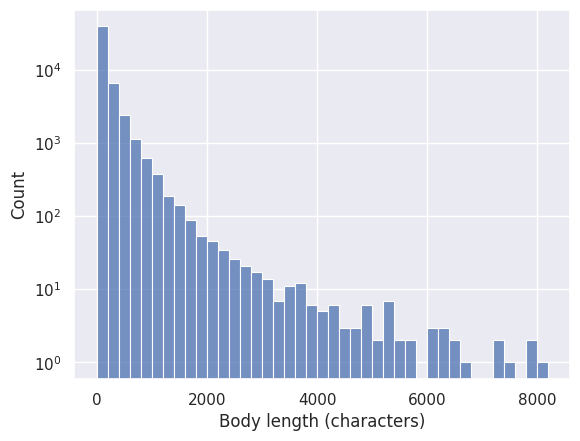

In [35]:
lengths = df["body"].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log")

In [36]:
df[lengths > 10000]

,index,name,subreddit,time,body,id
1869,36385,ca06ttw,mindcrack,2013-05-16 17:51:52,There you go ya bot. Okay: Will Sobriety get K...,26726368388


### Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

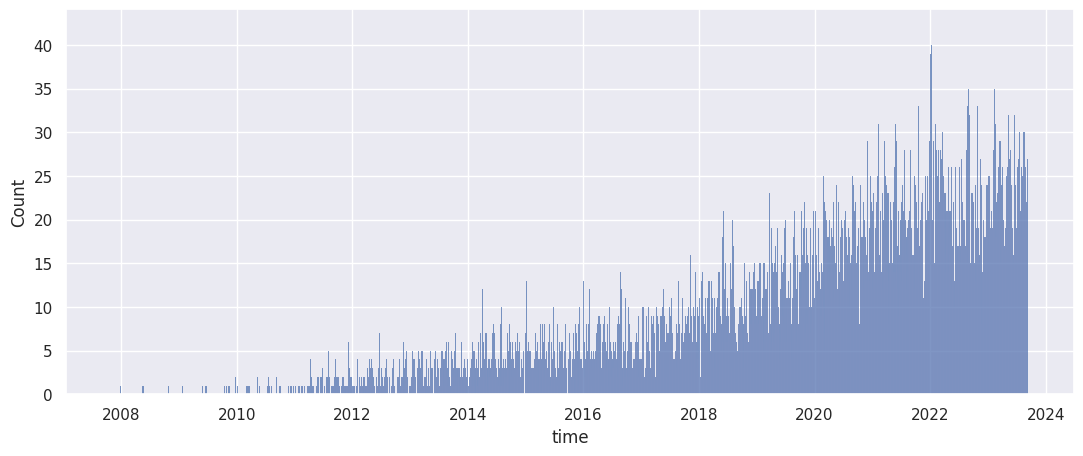

In [17]:
from datetime import timedelta

plt.figure(figsize=(13, 5))
sns.histplot(data=df, x="time", binwidth=timedelta(days=30))

<Axes: xlabel='time', ylabel='Count'>

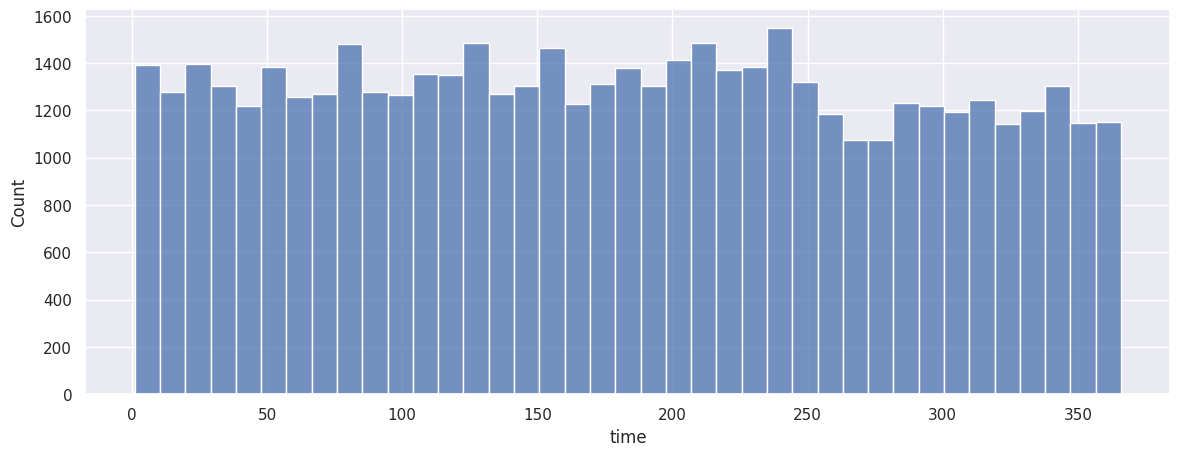

In [35]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df["time"].apply(lambda t: int(t.strftime("%j"))))

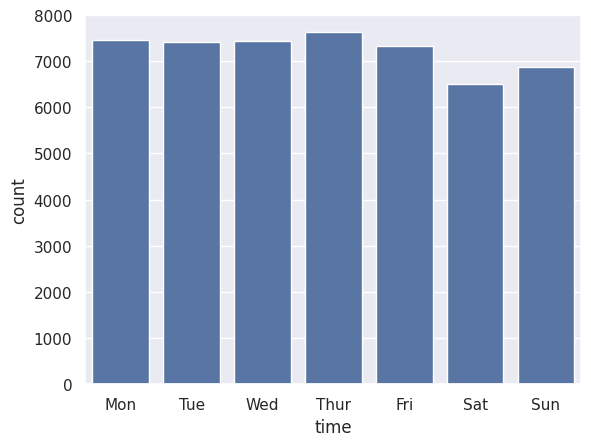

In [43]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df["time"].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

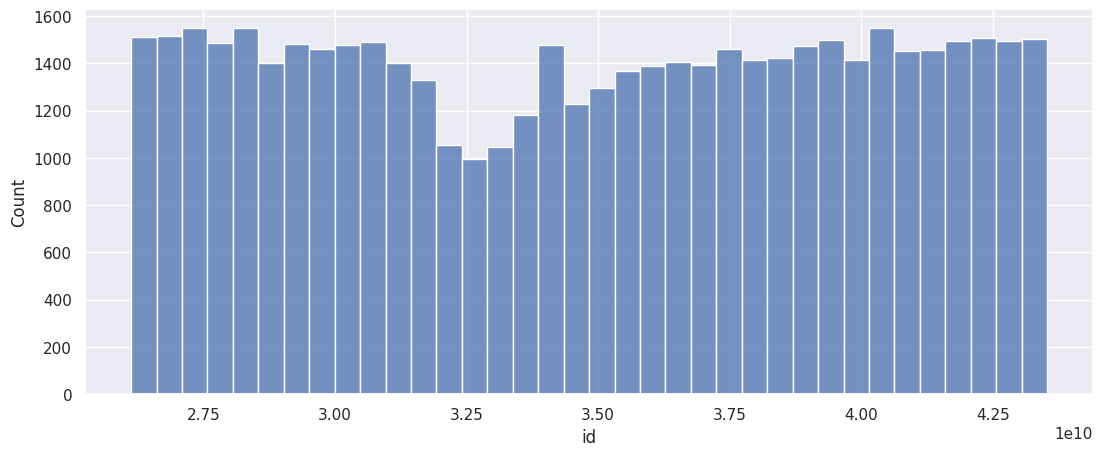

In [6]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df["id"])

In [19]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df["id"].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are uniformly distributed! (probably)")
else:
    print("Cannot assume distribution of IDs is uniform :(")
res

IDs are uniformly distributed! (probably)


KstestResult(statistic=0.01773736425196426, pvalue=2.834512435074989e-14, statistic_location=0.2932092352939838, statistic_sign=1)

In [49]:
# The earliest comment we have
df[df["id"] == df["id"].min()]

,index,name,subreddit,time,body,id
0,11599,c02dmtj,reddit.com,2007-11-04 21:14:36,"Probably the rock ad. Yeah, definitely the ro...",26125383367


In [8]:
misses = pd.Series(int(id, 36) for id in open("misses.txt", "r"))
misses

0         3983123541
1        25698587140
2        18961999379
3        12934330486
4        11977201267
            ...     
92643    28497079434
92644    24294658277
92645    20600546062
92646    21637711693
92647    20292358244
Length: 92648, dtype: int64

<Axes: >

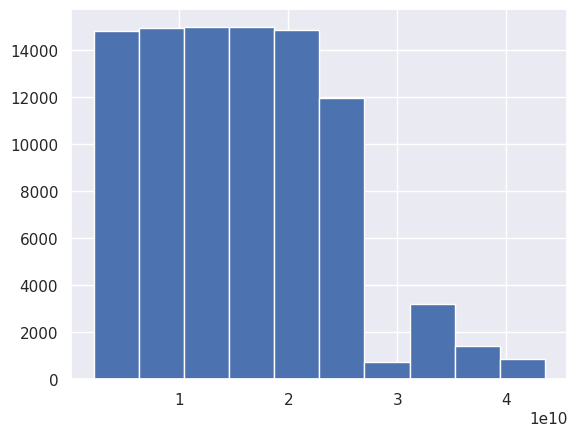

In [51]:
misses.hist()

<Axes: ylabel='Count'>

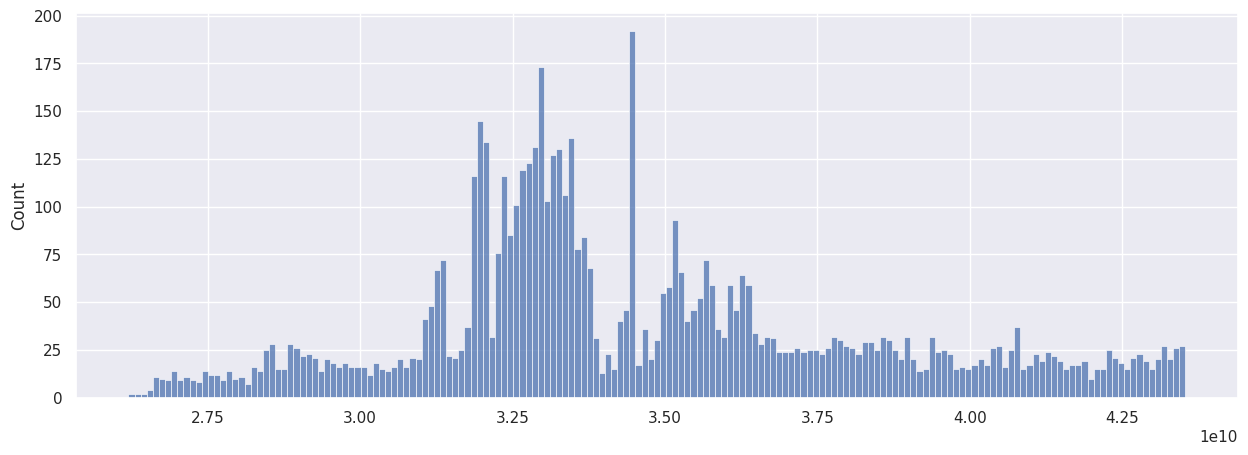

In [9]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

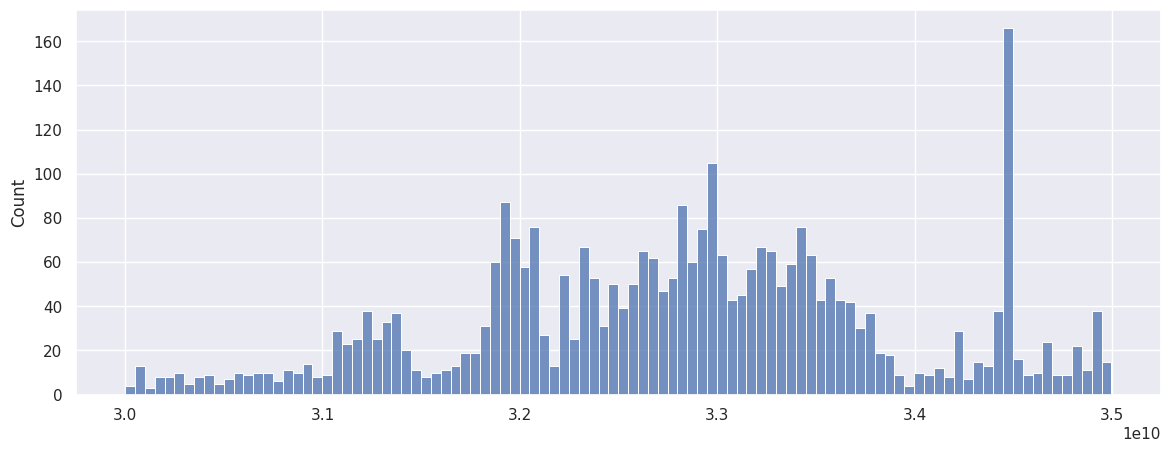

In [10]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.5e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [77]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.3534817833541517, 0.8920646661031276)

<Axes: xlabel='id', ylabel='rate'>

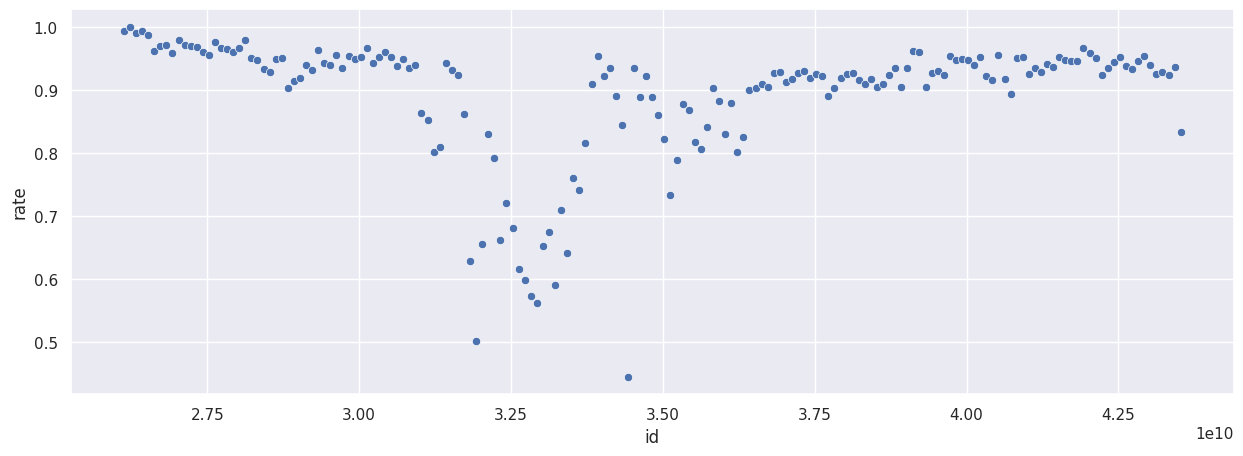

In [144]:
# Hit rate over time
start = first_id_actual
end = max(df.loc[len(df) - 1]["id"], misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df["id"]) & (df["id"] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if hits == 0:
        return 0
    return hits / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.scatterplot(data=rate_df, x="id", y="rate")

In [14]:
df[(3e10 <= df["id"]) & (df["id"] < 3.5e10)]

,index,name,subreddit,time,body,id
11980,43293,ds5lihp,EDC,2018-01-03 19:42:40,"That's awesome, good eye for a cool use!",30000625117
11981,45279,ds63onp,youtube,2018-01-04 02:48:17,"""Put ~~Jake's~~ Logan's name in your title and...",30001472917
11982,36116,ds64vhs,Retconned,2018-01-04 03:32:41,"Sure, it's Lunar Orbiter 3 from 1967 [pic...",30001528432
11983,13764,ds681vl,SquaredCircle,2018-01-04 05:44:19,I would rather take a stiff headbutt from Suzuki.,30001676673
11984,38627,ds6as0e,AsianBeautyAdvice,2018-01-04 07:27:40,The skin in question is mostly right under the...,30001803854
...,...,...,...,...,...,...
25111,9812,g2s487e,AskReddit,2020-08-25 04:08:24,"2002, it was the year that decided I should exist",34996676234
25112,36559,g2s6uft,HardwareSwapUK,2020-08-25 04:56:07,It's a bit too high priced for me but thanks f...,34996798361
25113,20381,g2s8vx6,AskReddit,2020-08-25 05:33:51,**PLEASE READ THIS MESSAGE IN ITS ENTIRETY BEF...,34996893594
25114,42539,g2sbt35,AskReddit,2020-08-25 06:26:22,""" How did I get on the Internatuonal Space sta...",34997029889


In [17]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = misses_actual.map(
    lambda id: (id - misses_actual.mean()) / (misses_actual.std())
)
res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are normally distributed! (probably)")
else:
    print("Cannot assume distribution of IDs is normal :(")
res

Misses are normally distributed! (probably)


KstestResult(statistic=0.11234964159704042, pvalue=7.664043311318156e-68, statistic_location=-0.22690747233129152, statistic_sign=1)

# `random()` Endpoint

In [59]:
all_sr = reddit.subreddit("all")
with open("random-posts.csv", "a") as file:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
    while True:
        try:
            post = all_sr.random()
            writer.writerow(post_relevant_fields(post))
        except Exception as e:
            print(e, e.__class__, id)
            break

KeyboardInterrupt: 

### Loading posts

In [60]:
df = pd.read_csv("random-posts.csv", names=POST_COLS)

df.drop_duplicates(subset=["id"], inplace=True)
df["time"] = df["time"].map(lambda ts: datetime.fromtimestamp(ts).date())
df["body"] = df["body"].fillna("")
assert not df.isna().values.any()

df

,id,time,subreddit,author,title,body,num_comments
0,1cdirkn,2024-04-26,StupidFood,zi6xd,Hot cold drink 🤦,,411
1,1cdvq9s,2024-04-26,psychedelicrock,ProjectConfident8584,Supertramp - Try Again,,0
2,1cdvqiy,2024-04-26,BrandonDE,HelicopterFar6349,Whoever supporting Dan Kuso are fucking stupid,Hate this guy,0
3,1cdvqah,2024-04-26,geometrydash,insane_demon_real,How different would the gd community be if Mic...,,0
4,1cdn255,2024-04-26,Grimdank,hydraphantom,Recent lore made Dark Eldars even more fucked up.,,154
...,...,...,...,...,...,...,...
127,1cdwhiw,2024-04-26,ShareYourSelfie,UnswornApproach78,"Sharing my selfie, can you describe it in a si...",,0
128,1cde9cz,2024-04-26,lgbt,AdamBladeTaylor,Warhammer is for everyone!,,422
129,1cdwhjv,2024-04-26,pokeplush,Even_Possession4614,Sitting Cuties from the restocks!!,,0
130,1cdulgr,2024-04-26,LiverpoolFC,Hoodxd,[Paul Joyce] Liverpool and Feyenoord have now ...,,234


In [61]:
ids = df["id"].apply(lambda id: int(id, 36))
ids.describe()

count    1.220000e+02
mean     2.925511e+09
std      2.593835e+05
min      2.924877e+09
25%      2.925278e+09
50%      2.925696e+09
75%      2.925718e+09
max      2.925727e+09
Name: id, dtype: float64

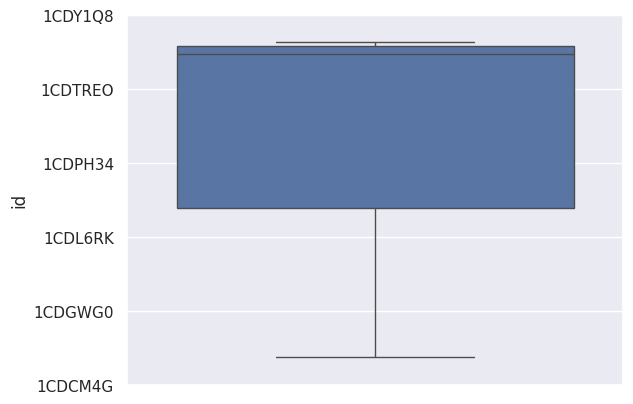

In [62]:
g = sns.boxplot(ids)
g.set_yticks(g.get_yticks(), labels=[np.base_repr(int(id), 36) for id in g.get_yticks()]);

# Distributed Sampling?

In [2]:
class Generator:
    def __init__(
        self,
        seed: int,
        end: int,
        step: int,
        iter_num: int = 0,
        id: Optional[int] = None,
    ):
        """
        # Parameters
        * `seed` - Seed to shuffle starts
        * `end` - Where the generator ends
        * `step` - Step size
        * `iter_num` - How many times we've reached `end` (0 for very start)
        * `id` - The last generated id"""

        self.end = end
        self.step = step

        rand = random.Random(seed)
        self.all_starts = list(range(step))
        rand.shuffle(self.all_starts)

        for _ in range(iter_num):
            self.all_starts.pop()

        if id is not None:
            self.id = id
        else:
            self.id = self.all_starts.pop() - step

    def get_state(self):
        iter_num = self.step - len(self.all_starts)
        return (self.seed, self.end, self.step, iter_num, self.id)

    def __next__(self):
        self.id = self.id + self.step
        if self.id <= self.end:
            return self.id

        self.id = self.all_starts.pop()
        return self.id

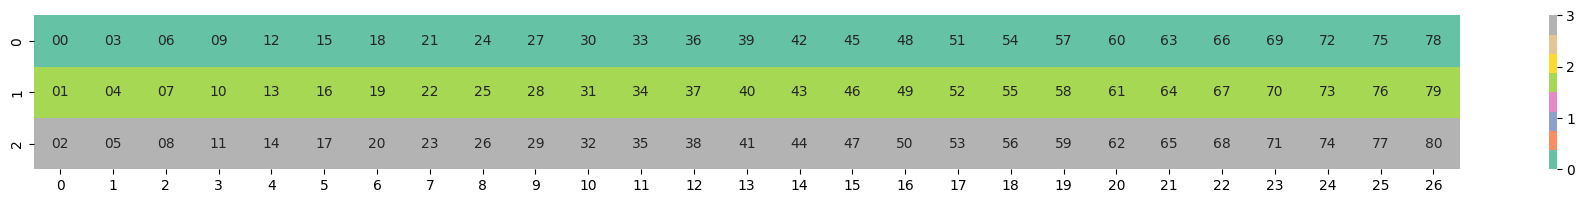

In [54]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


num_comps = 3
end = num_comps**4  # 81 IDs in all
gens = [
    Generator(seed=i, end=end // num_comps - 1, step=num_comps * num_comps)
    for i in range(num_comps)
]

mat = [[0 for _ in range(end // num_comps)] for _ in range(num_comps)]
ids = [[j * num_comps + i for j in range(end // num_comps)] for i in range(num_comps)]

fig = plt.figure(figsize=(23, 2))

def init():
    sns.heatmap(
        mat,
        vmin=0,
        vmax=len(gens),
        cbar_kws={"ticks": list(range(len(gens) + 1))},
        cmap=sns.color_palette("Set2"),
        annot=ids,
        fmt="02d",
        # square=True,
    )


def animate(i):
    for i, gen in enumerate(gens):
        id = next(gen)
        assert mat[i][id] == 0
        mat[i][id] = i + 1
    sns.heatmap(mat, cbar=False, cmap=sns.color_palette("Set2"))


anim = animation.FuncAnimation(
    fig, animate, init_func=init, repeat=False, frames=end // num_comps,
)
anim.save("foo.mp4")
plt.show()